In [135]:
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import regex as re

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
# from dateutil.parser import parse

### Cleaning date and time data for orders

In [77]:
# import excel file as pandas df
path = '../data/'
file = 'bakery_orders.xlsx'
pub_raw = pd.read_excel(path + file)
# create a copy 
pub = pub_raw.copy(deep=True)

In [78]:
# subset columns that will be worked on
pub = pub[['Submitted On', 'Pick Up Date', 'Pick Up Time',
            'What would you like to order']]

# lower the column names
pub.columns = pub.columns.str.lower()

# remove duplicates from dataset
pub = pub.drop_duplicates(subset='what would you like to order', keep='first')

In [79]:
#convert submission to date times separate month, year, time 
pub['submitted on']=pd.to_datetime(pub['submitted on'], dayfirst=False)
pub['order_date']=pd.to_datetime(pub['submitted on']).dt.date
pub['order_year']=pd.to_datetime(pub['submitted on']).dt.year
pub['order_month']=pd.to_datetime(pub['submitted on']).dt.month_name()
pub['order_time']=pd.to_datetime(pub['submitted on']).dt.time
pub['order_day']=pd.to_datetime(pub['submitted on']).dt.day_name()

In [80]:
# converting pu_datetime 
pub['pu_date'] = pd.to_datetime(pub['pick up date'], dayfirst=False)
pub['pu_month_name']=pd.to_datetime(pub['pu_date']).dt.month_name()
pub['pu_month']=pd.to_datetime(pub['pu_date']).dt.strftime('%m')
pub['pu_day_name']=pd.to_datetime(pub['pu_date']).dt.day_name()
pub['pu_day']=pd.to_datetime(pub['pu_date']).dt.strftime('%d')

In [81]:
# create new clean pu_date because some pu_year were before 2020 
pub['pu_date_clean']=pub[['order_year','pu_month','pu_day']].apply(lambda x: '-'.join(x.astype(str)), axis=1)

In [82]:
# change pick up time to string for cleaning
pub['pick up time'] = pub['pick up time'].astype(str)
# replace singular 0 to double 0s
pub['pick up time'] = pub['pick up time'].str.replace(r"\b(0)\b", "00", regex=True)

In [83]:
# convert pick up time to datetime format
pub['pu_time'] = pd.to_datetime(pub['pick up time'], infer_datetime_format=True, errors='coerce').dt.time

In [84]:
# convert remaining missings with wrong format (mixed 24H with AM/PM)
pub_na_pu_time = pub[pub['pu_time'].isna()]
pub['pu_time'] = pub['pu_time'].fillna(pd.to_datetime(pub_na_pu_time['pick up time'], format = '%H:%M:%S %p').dt.time)

In [85]:
# get the pick up hour only, round to lower hour
pub['pu_hour'] = pd.to_datetime(pub['pu_time'], format='%H:%M:%S').dt.hour

In [86]:
# function to correct errors when pick up hours are outside open hours
def open_hour_fix(x): 
    # before 7 AM
    if x < 7: 
        return x + 12 
    # after 7 PM
    elif x > 19:
        return x - 12
    else:
        return x

In [87]:
pub['pu_hour_clean'] = pub['pu_hour'].apply(open_hour_fix)

In [209]:
# revert back to time
pub['pu_hour_dt'] = pd.to_datetime(pub['pu_hour_clean'], format='%H').dt.strftime('%H:%M')
# change to string with H and M only
# pub['pu_hour_dt'] = pd.to_datetime(pub['pu_hour_dt']).strftime('%H:%M')

In [212]:
# keep: pu_date, order_year, pu_month, pu_day, pu_hour_dt

pub_clean = pub[['pu_date_clean', 'order_year', 'pu_month', 'pu_month_name', 'pu_day', 'pu_day_name', 'pu_hour_dt']]

In [213]:
pub_clean = pub_clean.rename(columns={
    'pu_date_clean':'pu_date', 
    'pu_month':'order_month', 
    'pu_month_name':'order_month_name', 
    'pu_hour_dt':'pu_hour'
    })

In [214]:
pub_clean.head()

,pu_date,order_year,order_month,order_month_name,pu_day,pu_day_name,pu_hour
0,2020-03-13,2020,03,March,13,Friday,16:00
1,2020-03-31,2020,03,March,31,Tuesday,10:00
2,2020-04-01,2020,04,April,01,Wednesday,09:00
3,2020-04-03,2020,04,April,03,Friday,11:00
4,2020-04-03,2020,04,April,03,Friday,13:00


<AxesSubplot:xlabel='count', ylabel='pu_hour'>

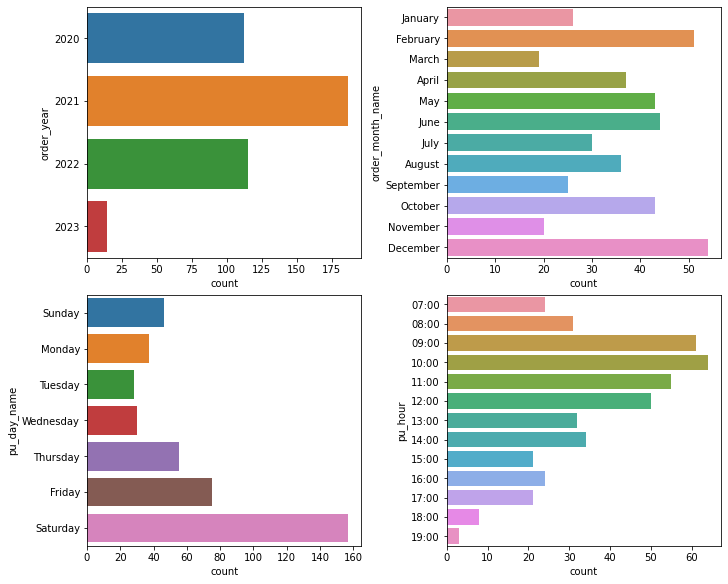

In [216]:
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

open_hours = sorted(list(pub_clean['pu_hour'].astype(str).unique()))

fig, axs = plt.subplots(2,2,figsize=(10,8), constrained_layout=True)

sns.countplot(y= pub_clean['order_year'], ax=axs[0,0])

sns.countplot(y= pub_clean['order_month_name'], order=month_order, ax=axs[0,1])

sns.countplot(y= pub_clean['pu_day_name'], order=day_order, ax=axs[1,0])

sns.countplot(y= pub_clean['pu_hour'], order=open_hours, ax=axs[1,1])

In [93]:
pub_clean.to_excel(path + 'bakery_orders_clean.xlsx')

### Cleaning up orders text

In [17]:
orders = pub[['what would you like to order']]

In [18]:
orders = orders.rename(columns={'what would you like to order': 'order'})

In [66]:
# remove punctuation 
import string
string.punctuation

def del_punct(text):
    text="".join([char for char in text if char not in string.punctuation])
    return text

# lower case text 
def lowercase(text):
    text=text.lower()
    return text

# deleting stop words
from nltk.corpus import stopwords
engStopWords = stopwords.words('english')

def del_stopWords(text):
    word_list = text.split()
    text = " ".join([word for word in word_list if word not in engStopWords])
    return text

# lemmatize words, removing plural 
from nltk import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

def lem_text(text):
    word_list = text.split()
    text = " ".join([lemmatizer.lemmatize(word) for word in word_list])
    return text


# Combining all pre-processing
def preprocess_text(text):
    text = lowercase(text)
    text= del_stopWords(text)
    text = lem_text(text)
    text = del_punct(text)
    return text

In [67]:
orders['order'] = orders['order'].astype(str)

In [122]:
orders

,order,order_test,order_test2
0,1 dozen vanilla cupcakes (no sprinkle)\n1 doze...,dozen vanilla cupcakes (no sprinkle) dozen va...,dozen vanilla cupcake no sprinkle dozen vanill...
1,"Can I please order 4 pizza doughs, 2 dozen cru...","Can I please order pizza doughs, dozen crusty ...",please order pizza doughs dozen crusty rolls f...
2,"I would like to order 12 spinach empanadas , a...","I would like to order spinach empanadas , a do...",would like order spinach empanadas dozen donu...
3,"6 donuts - 2 Boston crème, 2 glaze, 2 vanilla ...","donuts - Boston crème, glaze, vanilla sprinkl...",donut boston crème glaze vanilla sprinkle if ...
4,"May I please have 4 pizza doughs, and 20 of yo...","May I please have pizza doughs, and of r tim b...",may please pizza doughs r tim bit the powdered...
...,...,...,...
391,Apple pie-1\nBlueberry pie-1\nPumpkin pie -1 (...,Apple pie- Blueberry pie- Pumpkin pie - (if d...,apple pie blueberry pie pumpkin pie if don’t ...
392,Ensaymada - Box $16\nEmpanadas - 1 Dozen Chick...,Ensaymada - Box $ Empanadas - Dozen Chicken $,ensaymada box empanadas dozen chicken
393,"Half dozen Donuts \nChocolate dipped, Vanilla ...","Half dozen Donuts Chocolate dipped, Vanilla di...",half dozen donut chocolate dipped vanilla dipp...
394,UBE & CHEESE PANDESAL - 2 boxes of 6 pcs\nEnsa...,UBE & CHEESE PANDESAL - boxes of pcs Ensaymada...,ube cheese pandesal box pc ensaymada half d...


In [123]:
orders['order_test2'] = orders['order_test'].apply(lambda x: preprocess_text(x))

In [124]:
orders.head()

,order,order_test,order_test2
0,1 dozen vanilla cupcakes (no sprinkle)\n1 doze...,dozen vanilla cupcakes (no sprinkle) dozen va...,dozen vanilla cupcake no sprinkle dozen vanill...
1,"Can I please order 4 pizza doughs, 2 dozen cru...","Can I please order pizza doughs, dozen crusty ...",please order pizza doughs dozen crusty rolls f...
2,"I would like to order 12 spinach empanadas , a...","I would like to order spinach empanadas , a do...",would like order spinach empanadas dozen donu...
3,"6 donuts - 2 Boston crème, 2 glaze, 2 vanilla ...","donuts - Boston crème, glaze, vanilla sprinkl...",donut boston crème glaze vanilla sprinkle if ...
4,"May I please have 4 pizza doughs, and 20 of yo...","May I please have pizza doughs, and of r tim b...",may please pizza doughs r tim bit the powdered...


In [125]:
print(orders['order_test2'][3])

donut  boston crème glaze vanilla sprinkle if boston crème sub chocolate dip hot dog bun whole wheat bread thank 


In [73]:
from sklearn.feature_extraction.text import CountVectorizer

In [110]:
cvec = CountVectorizer(ngram_range=(1,2), max_df=0.95, min_df=0.05)

In [111]:
word_count_vector = cvec.fit_transform(orders['order_test2'])

In [112]:
orders_wordcount = pd.DataFrame(word_count_vector.toarray())
orders_wordcount.columns = cvec.get_feature_names_out()

In [113]:
orders_wordcount.shape

(392, 86)

In [114]:
orders_wordcount

,apple,asado,blueberry,boston,boston cream,box,bread,bun,butter,butter tart,...,sugar coated,tart,thank,thank you,twist,vanilla,vanilla dip,vanilla dipped,white,you
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,2,0
3,0,0,0,2,0,0,1,1,0,0,...,0,0,1,1,0,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
390,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
orders_wordcount.columns

Index(['apple', 'asado', 'blueberry', 'boston', 'boston cream', 'box', 'bread',
       'bun', 'butter', 'butter tart', 'cheese', 'cherry', 'chicken',
       'chicken empanada', 'chicken empanadas', 'chip', 'chocolate',
       'chocolate chip', 'chocolate dip', 'chocolate dipped', 'cinnamon',
       'cinnamon twist', 'coated', 'cream', 'croissant', 'cupcake', 'danish',
       'dip', 'dipped', 'dipped plain', 'dipped sprinkled', 'donut',
       'donut dozen', 'donut half', 'dough', 'dozen', 'dozen chicken',
       'dozen chocolate', 'dozen donut', 'dozen pork', 'dozen spinach',
       'dutchie', 'empanada', 'empanadas', 'empanadas dozen', 'ensaymada',
       'filled', 'glazed', 'half', 'half dozen', 'honey', 'honey glazed',
       'hot', 'jelly', 'jelly filled', 'lemon', 'loaf', 'maple', 'muffin',
       'one', 'order', 'pandesal', 'pie', 'plain', 'please', 'pork',
       'pork empanadas', 'raisin', 'sliced', 'spinach', 'spinach cheese',
       'sprinkle', 'sprinkled', 'sprinkles', 'stra

In [20]:
# pu_time[pu_time['clean1'].str.contains('AM')]

In [75]:
# pub.groupby(['order_date'])['order_date'].count().sort_values()
# for seeing what dates have the most orders 

In [95]:
# pub[pub['pick up time'].str.contains('AM|PM')==True]
# pub[pub['pick up time'].str.contains('null')==True]

# pub[(pub['order_year']==2022) & (pub['pick up time'].str.contains('PM')==True)]

In [9]:
#pub2ampm = pd.to_datetime(pub2[pub2['Pick Up Time'].str.contains('PM')], format = '%H:%M:%S %p')
pub2['pickup_time']=pd.to_datetime(pub2['Pick Up Time'],infer_datetime_format=True, errors='coerce')
pub2na=pub2[pub2['pickup_time'].isna()]
pub2nadt=pd.to_datetime(pub2na['Pick Up Time'], format = '%H:%M:%S %p')
pub2['pickup_time']=pub2['pickup_time'].fillna(pub2nadt)

In [10]:
#Combines date and times to one datetime value
pub2['pickup_date']=pub2['pickup_date'].astype(str)
pub2['pickup_time']=pub2['pickup_time'].dt.time.astype(str)
pub2['pickup_datetime']=pd.to_datetime(pub2['pickup_date'] + ' ' + pub2['pickup_time'])

In [11]:
#Chooses times that are before 6am and adds 12 hours to be 24H clock
beforeopen=pub2['pickup_datetime'].dt.hour < 6
pub2.loc[beforeopen, 'pickup_datetime'] = pub2['pickup_datetime'] + timedelta(hours=12)

In [18]:
#Separates date and times
pub2['pickup_date']=pub2['pickup_datetime'].dt.date
pub2['pickup_time']=pub2['pickup_datetime'].dt.time
pickuphour=pub2['pickup_datetime'].dt.hour
pickupday=pub2['pickup_datetime'].dt.strftime('%A')
pickupmonth=pub2['pickup_datetime'].dt.month

<AxesSubplot:xlabel='pickup_datetime', ylabel='Count'>

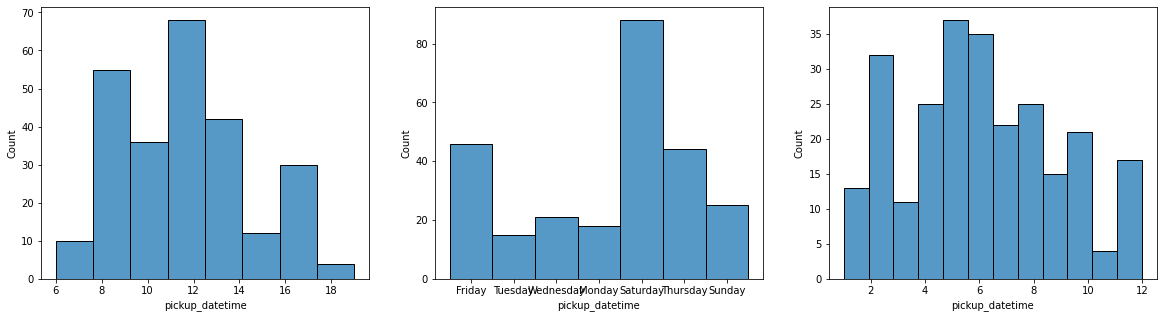

In [29]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.histplot(pickuphour, ax=ax[0], bins=8)
sns.histplot(pickupday, ax=ax[1])
sns.histplot(pickupmonth, ax=ax[2], bins=12)